**Objective:** This is an exploration of 2 unsupervised techniques used to detect anomalies, LOF and K-Means. 
    
We will explore an ensemble approach that theorically will leverage the strengths of both clustering and local density-based anomaly detection. The caveat is the technique are primarily for numerical variables.

The dataset is on claims submitted by medical providers.

In [1]:
import os
import sys

import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

user = os.environ.get("USER")
sys.path.append(f"/Users/{user}/utils/")

In [2]:
data_path = f"/Users/{user}/data/Provider_Anomaly_Dataset.csv"

### Load Dataset

In [3]:
df = pd.read_csv(data_path, low_memory=False)

In [4]:
df['Claims_Count'] = df['Claims_Count'].round(0)
df['Patient_Count'] = df['Patient_Count'].round(0)

In [5]:
df.head()

,Provider_ID,Claim_Amount,Claims_Count,Patient_Count,Average_Treatment_Cost
0,12595,2397.37,15.0,14.0,202.42
1,15440,1889.39,22.0,6.0,174.39
2,14389,2518.15,23.0,17.0,113.29
3,18290,3218.42,18.0,11.0,142.92
4,14631,1812.68,21.0,12.0,229.92


### Summary Statistics

In [6]:
df['Claim_Amount'].describe()

count     1000.000000
mean      2275.653093
std       2209.000456
min       -593.010000
25%       1501.752500
50%       2041.700000
75%       2549.787500
max      31731.721560
Name: Claim_Amount, dtype: float64

In [7]:
df['Claims_Count'].describe()

count    1000.000000
mean       21.201000
std        10.636905
min         7.000000
25%        17.000000
50%        20.000000
75%        23.000000
max       155.000000
Name: Claims_Count, dtype: float64

In [8]:
df['Patient_Count'].describe()

count    1000.00000
mean       14.82100
std         3.86418
min         4.00000
25%        12.00000
50%        15.00000
75%        17.00000
max        28.00000
Name: Patient_Count, dtype: float64

In [9]:
df['Average_Treatment_Cost'].describe()

count    1000.000000
mean      154.001801
std        70.954073
min         5.020000
25%       115.690000
50%       148.920000
75%       182.980000
max       849.888269
Name: Average_Treatment_Cost, dtype: float64

### k-means clustering

In [10]:
feature_cols = ['Claim_Amount', 'Claims_Count', 'Patient_Count', 'Average_Treatment_Cost']
df_scaled = StandardScaler().fit_transform(df[feature_cols])

In [11]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df_scaled)

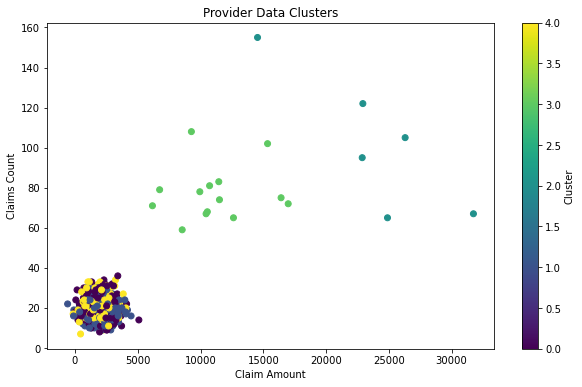

In [12]:
plt.figure(figsize=(10, 6))

plt.scatter(df['Claim_Amount'], df['Claims_Count'], c=df['cluster'], cmap='viridis')
plt.xlabel('Claim Amount')
plt.ylabel('Claims Count')
plt.title('Provider Data Clusters')
plt.colorbar(label='Cluster')
plt.show()

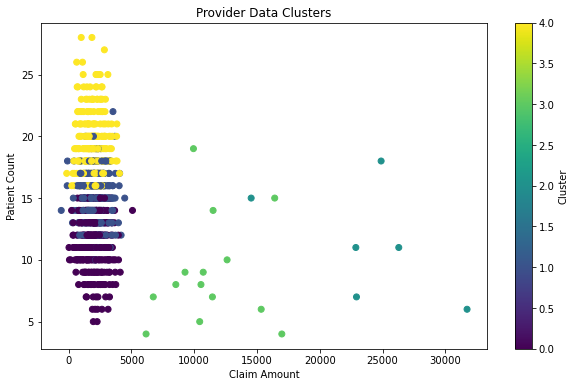

In [13]:
plt.figure(figsize=(10, 6))

plt.scatter(df['Claim_Amount'], df['Patient_Count'], c=df['cluster'], cmap='viridis')
plt.xlabel('Claim Amount')
plt.ylabel('Patient Count')
plt.title('Provider Data Clusters')
plt.colorbar(label='Cluster')
plt.show()

**Purple Cluster**: Low claim amount with varying patient counts

**Blue and Yellow Clusters**: Moderate claim amount with medium patient counts

**Green Clusters**: High claim amount with lower patient counts

**Takeaway**: The focus should be on green clusters. Providers that are far right on the plot (high claim amount) but down towards the bottom (low patient count) could be outliers or anomalies. This observation could be indicative of high-cost specialty providers or possibly providers whose suspicious billing practices.

Next, we will look at the providers that are outliers within their respective clusters.

### Local Outlier Factor

In [14]:
features_of_interest = df[['Claim_Amount', 'Claims_Count', 'Patient_Count', 'Average_Treatment_Cost']]

In [15]:
# Normalizing these features to set them to a same scale
scaler = StandardScaler()
norm_features = scaler.fit_transform(features_of_interest)

In [16]:
# Calculate LOF score
lof = LocalOutlierFactor(n_neighbors=20)
lof_scores = lof.fit_predict(norm_features)  # -1 for outliers
lof_neg_scores = -lof.negative_outlier_factor_  # negative scores, more negative means more outlier

In [17]:
df['LOF_Score'] = lof_neg_scores

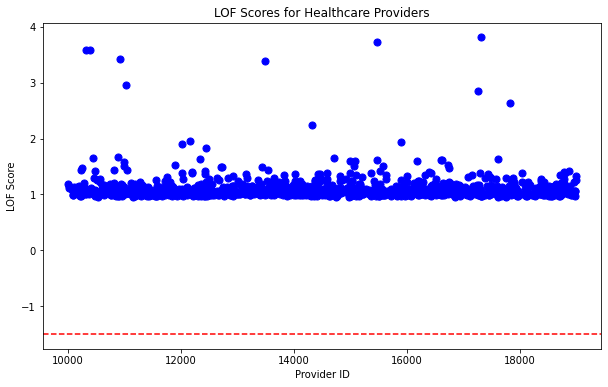

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Provider_ID'], df['LOF_Score'], color='blue', s=50)
plt.axhline(y=-1.5, color='r', linestyle='--')  # example threshold for outliers
plt.xlabel('Provider ID')
plt.ylabel('LOF Score')
plt.title('LOF Scores for Healthcare Providers')
plt.grid(False)
plt.show()

### LOF within Each Cluster

In [19]:
df['LOF_Score'] = 0

In [20]:
for c in df['cluster'].unique():
    cluster_data = df[df['cluster'] == c][feature_cols]
    lof = LocalOutlierFactor(n_neighbors=5)
    df.loc[df['cluster'] == c, 'LOF_Score'] = lof.fit_predict(cluster_data)

In [21]:
# Identifying outliers
df['Outlier'] = df['LOF_Score'] <= -1

In [22]:
df[df['Outlier'] == True].head()

,Provider_ID,Claim_Amount,Claims_Count,Patient_Count,Average_Treatment_Cost,cluster,LOF_Score,Outlier
11,13813,1627.42000,22.0,19.0,252.110000,4,-1,True
29,15090,16410.10753,75.0,15.0,849.888269,3,-1,True
30,13565,1518.63000,18.0,14.0,259.250000,0,-1,True
48,17493,2274.89000,19.0,23.0,89.170000,4,-1,True
57,16742,1752.63000,22.0,8.0,82.950000,0,-1,True


In [23]:
df.Outlier.value_counts(2)

False    0.945
True     0.055
Name: Outlier, dtype: float64

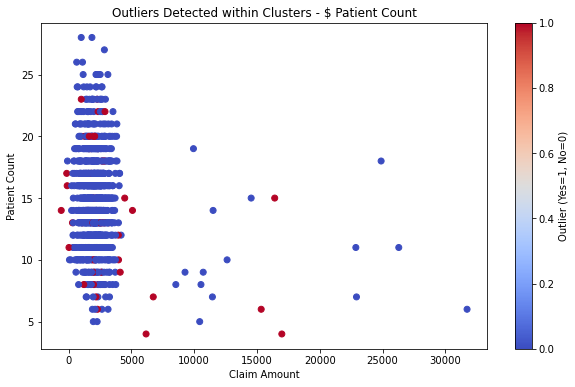

In [24]:
plt.figure(figsize=(10, 6))

plt.scatter(df['Claim_Amount'], df['Patient_Count'], c=df['Outlier'], cmap='coolwarm')
plt.xlabel('Claim Amount')
plt.ylabel('Patient Count')
plt.title('Outliers Detected within Clusters - $ Patient Count')
plt.colorbar(label='Outlier (Yes=1, No=0)')
plt.show()

Red indicates Outliers. We can observe that they are scattered throughout but are particularly noticeable in areas with either high claim amounts or very low patient counts

**Takeaway**: providers with high claim amounts and relatively fewer patients may require audits to verify the legitimacy of the claims filed.
    
Additional statistical analyses are needed on both the outliers and the dense clusters to understand the underlying causes of such distributions. We can look at data such as types of treatment provided, demographic information of patients, or geographical factors to get a deeper insights into why certain providers are outliers.

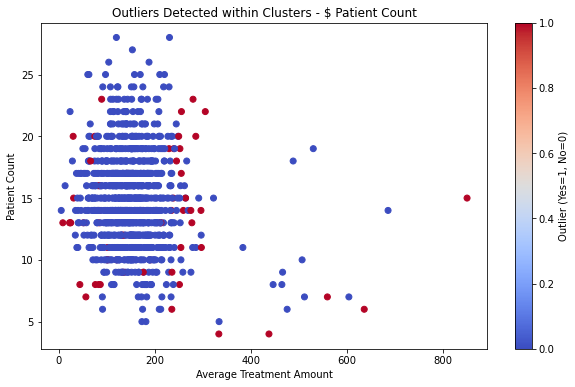

In [25]:
plt.figure(figsize=(10, 6))

plt.scatter(df['Average_Treatment_Cost'], df['Patient_Count'], c=df['Outlier'], cmap='coolwarm')
plt.xlabel('Average Treatment Amount')
plt.ylabel('Patient Count')
plt.title('Outliers Detected within Clusters - $ Patient Count')
plt.colorbar(label='Outlier (Yes=1, No=0)')
plt.show()

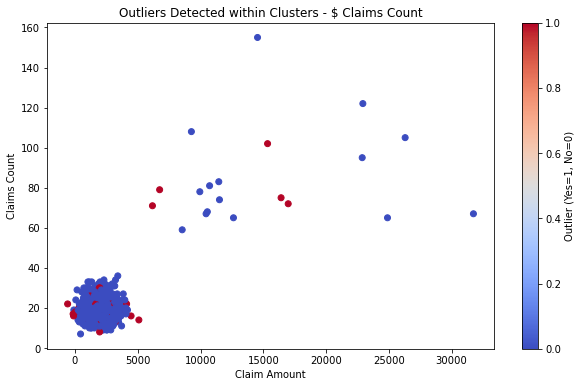

In [26]:
plt.figure(figsize=(10, 6))

plt.scatter(df['Claim_Amount'], df['Claims_Count'], c=df['Outlier'], cmap='coolwarm')
plt.xlabel('Claim Amount')
plt.ylabel('Claims Count')
plt.title('Outliers Detected within Clusters - $ Claims Count')
plt.colorbar(label='Outlier (Yes=1, No=0)')
plt.show()

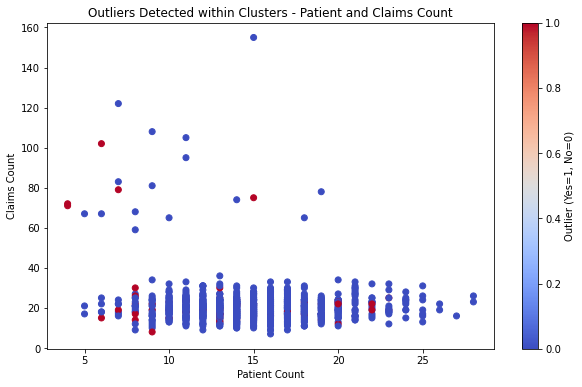

In [27]:
plt.figure(figsize=(10, 6))

plt.scatter(df['Patient_Count'], df['Claims_Count'], c=df['Outlier'], cmap='coolwarm')
plt.xlabel('Patient Count')
plt.ylabel('Claims Count')
plt.title('Outliers Detected within Clusters - Patient and Claims Count')
plt.colorbar(label='Outlier (Yes=1, No=0)')
plt.show()